<a href="https://colab.research.google.com/github/MWANIKID/PhD-Research-files/blob/main/Safaricom_Bitcoin_test24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
from google.colab import files
uploaded = files.upload()

Saving Safaricom Data.csv to Safaricom Data (4).csv
Saving Bitcoin_data.csv to Bitcoin_data (4).csv


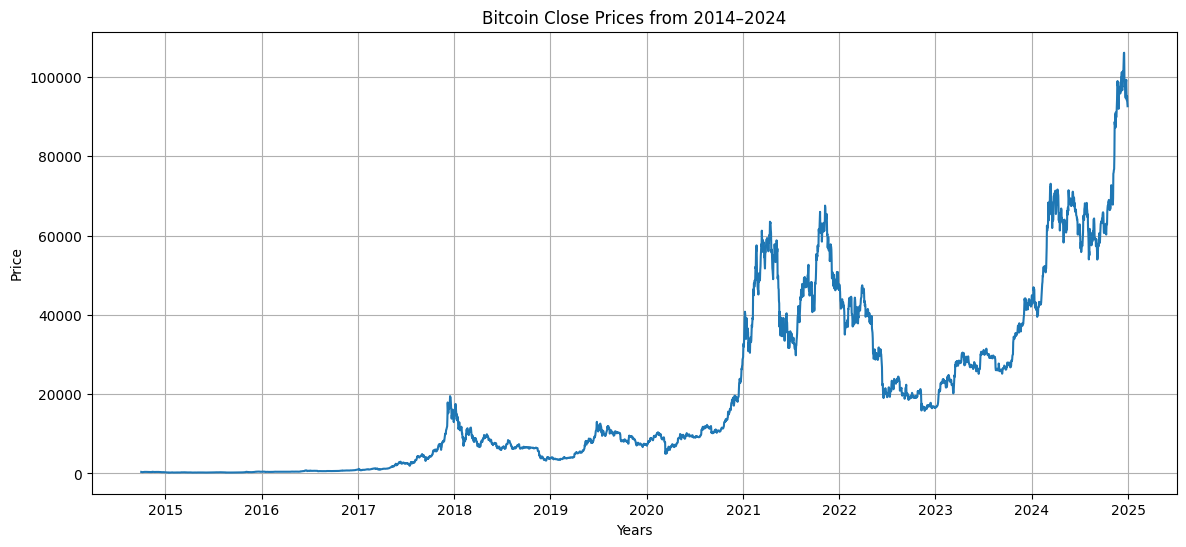

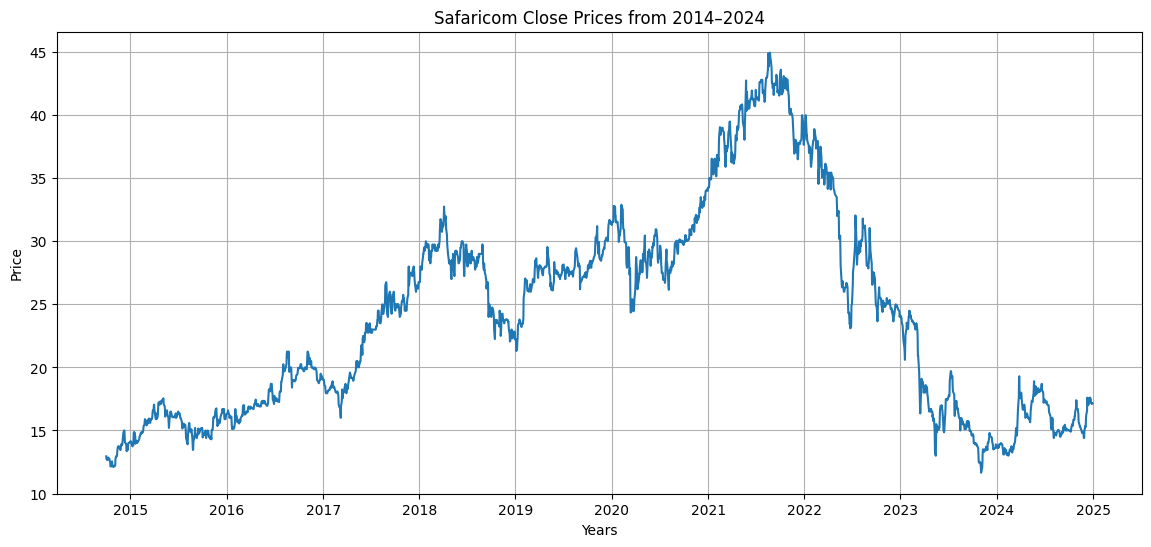

<ipython-input-56-be4e13f4e9ea>:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df['Close'].resample('M').mean()
<ipython-input-56-be4e13f4e9ea>:52: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly = df['Close'].resample('Y').mean()


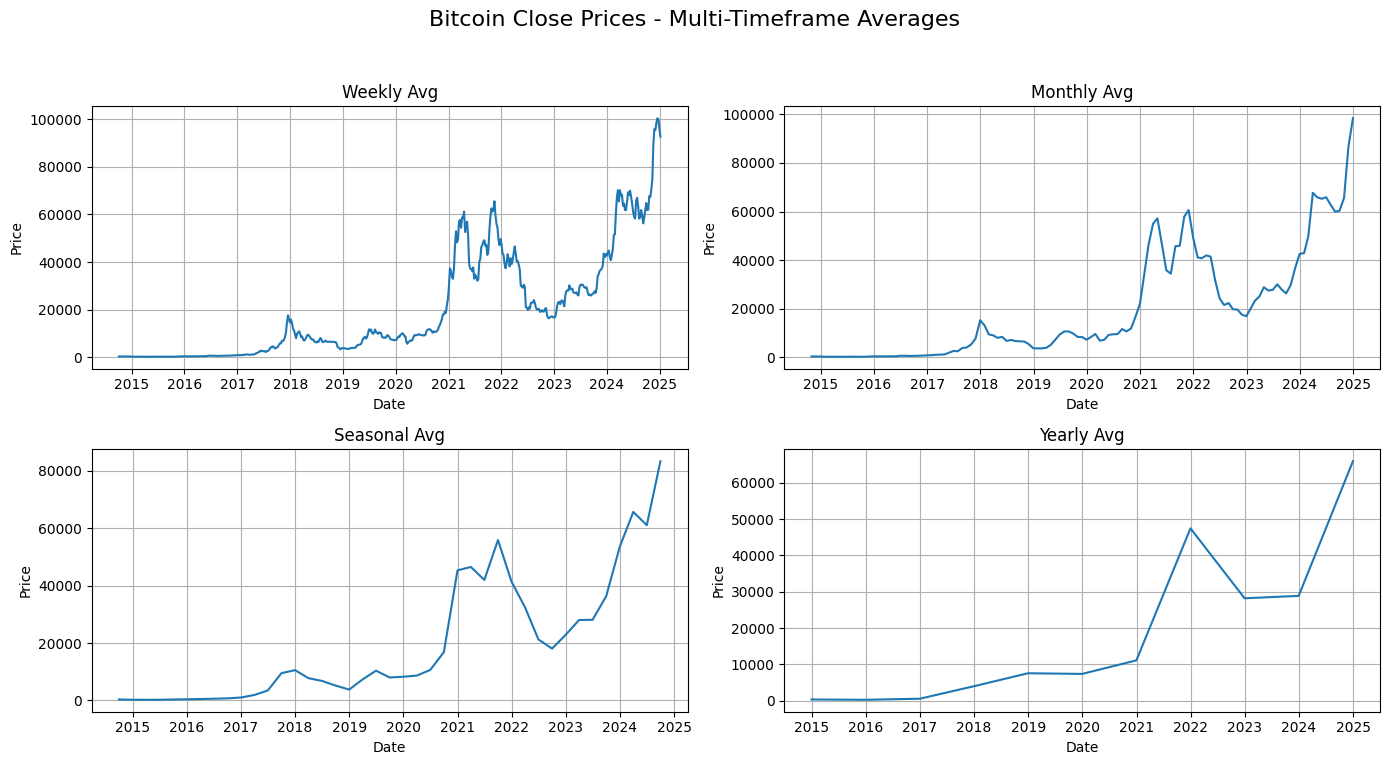

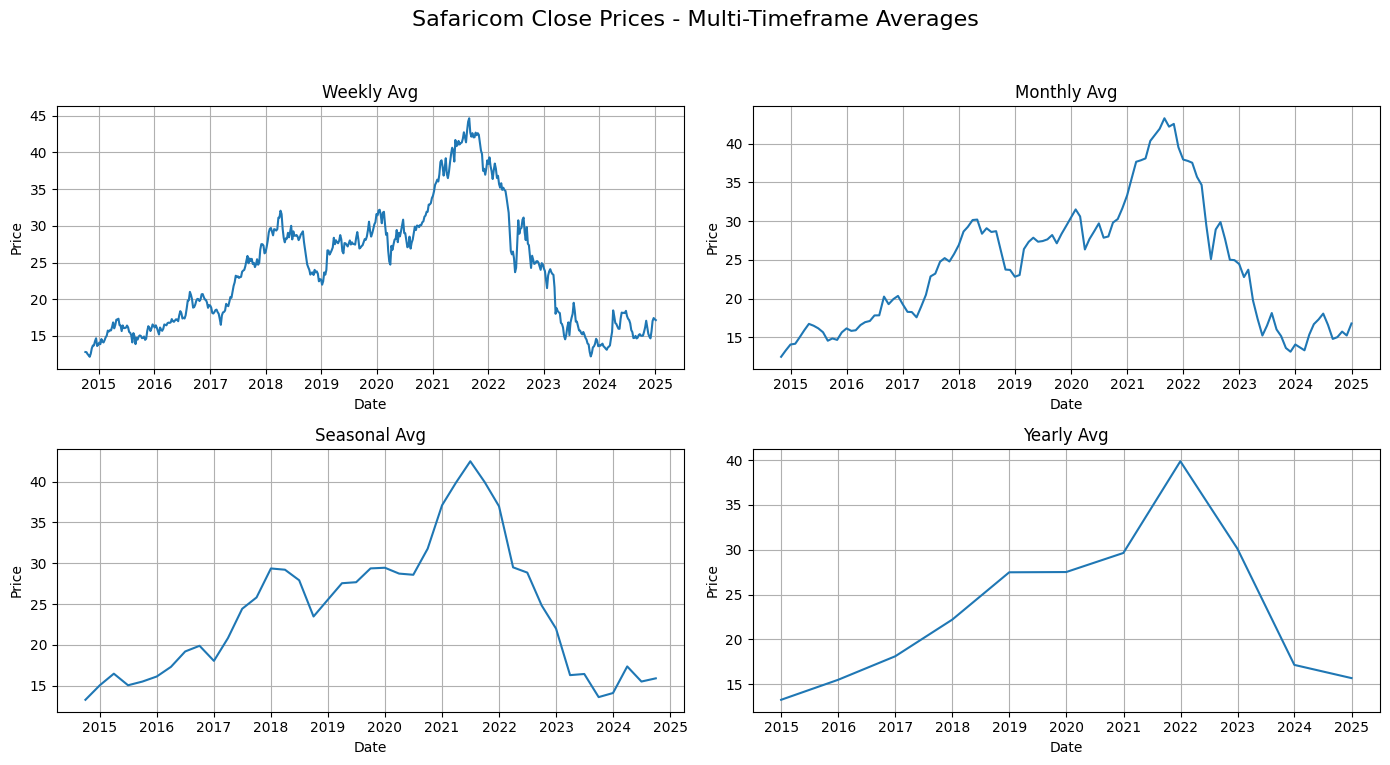

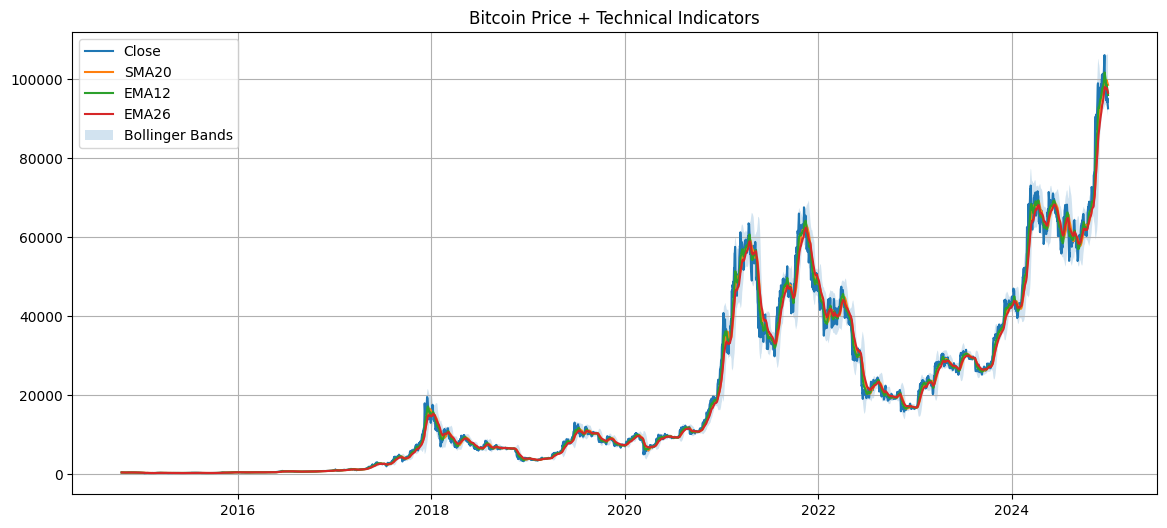

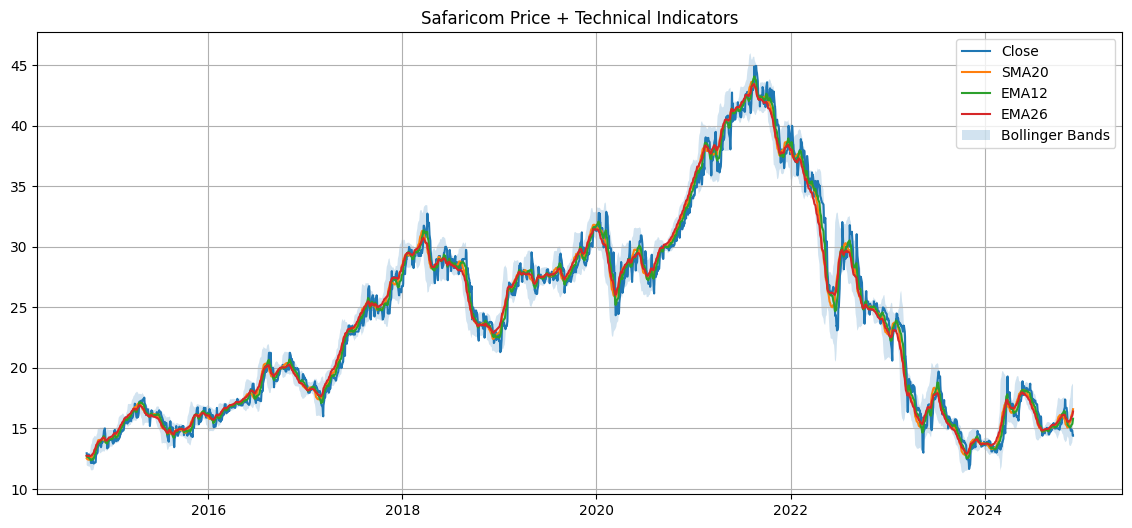

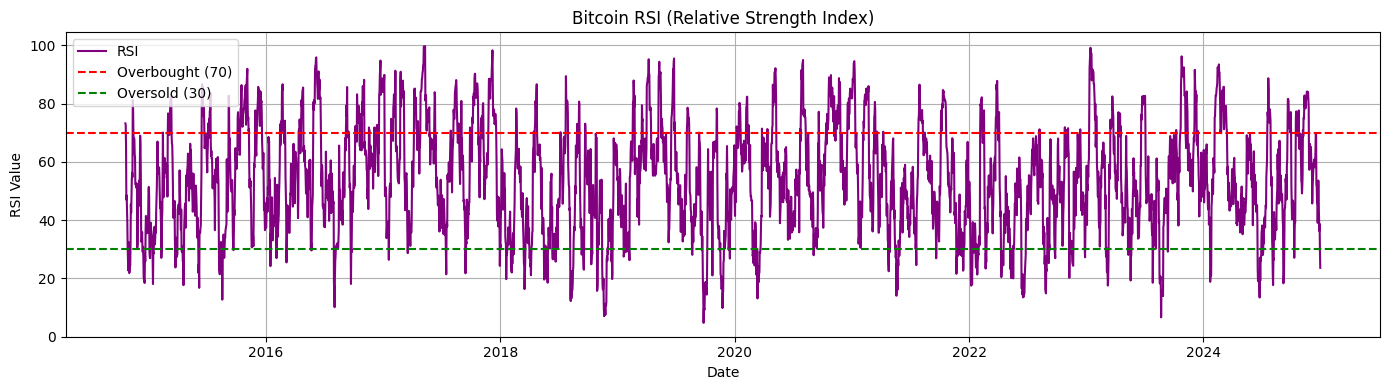

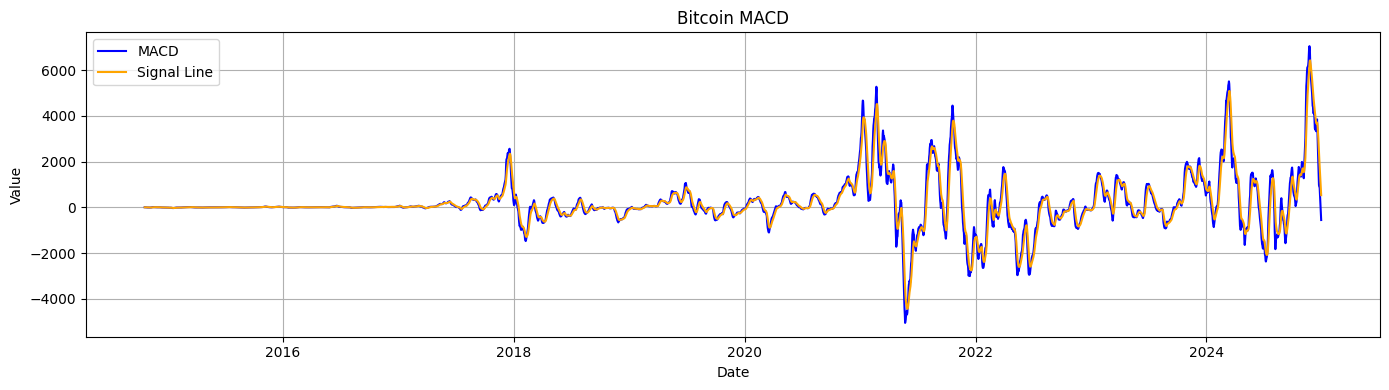

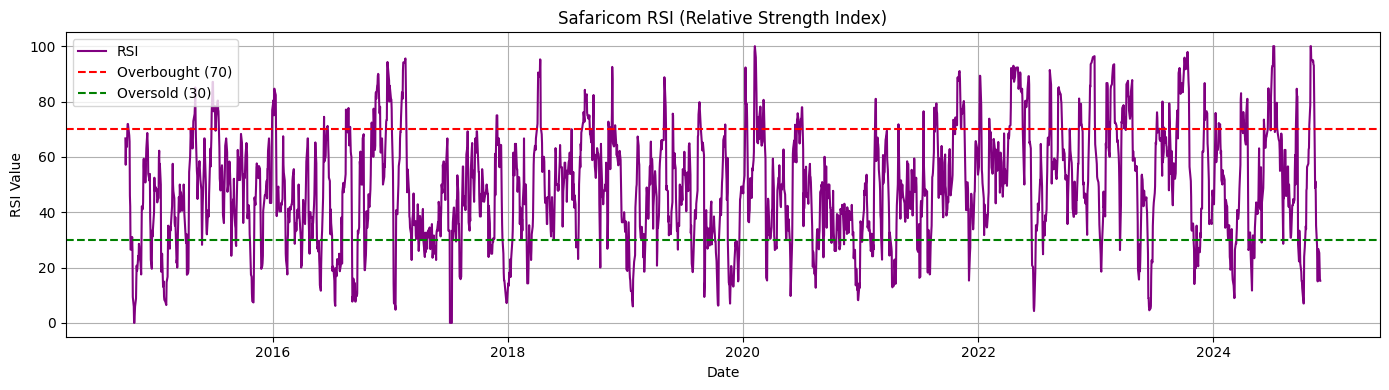

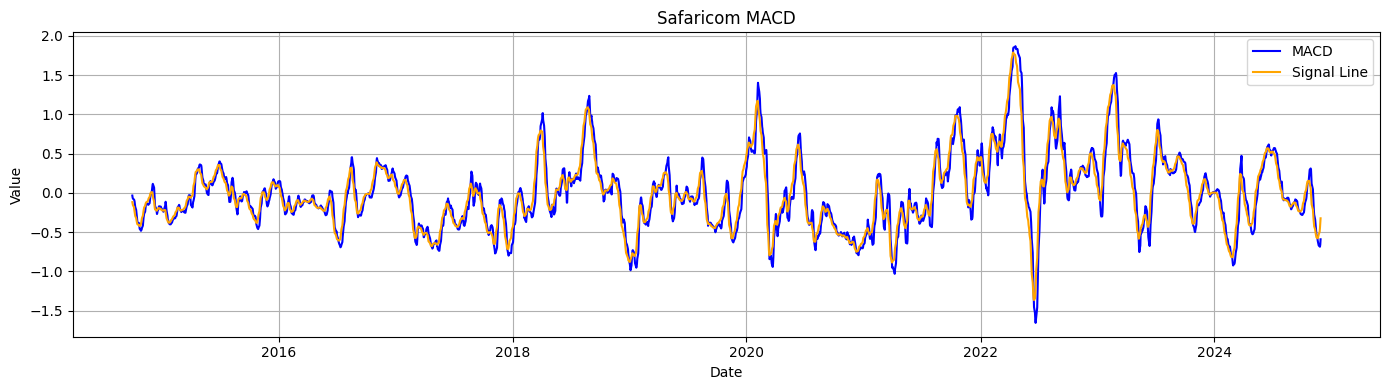

In [56]:
# ✅ Load datasets
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Read with proper header row (header=0), parse dates with dayfirst
btc = pd.read_csv("Bitcoin_data.csv", parse_dates=["Date"], dayfirst=True)
safaricom = pd.read_csv("Safaricom Data.csv", parse_dates=["Date"], dayfirst=True)

# ✅ Clean column names: remove leading/trailing spaces
btc.columns = btc.columns.str.strip()
safaricom.columns = safaricom.columns.str.strip()

# ✅ Set date index
btc.set_index("Date", inplace=True)
safaricom.set_index("Date", inplace=True)

# Drop missing values
btc.dropna(inplace=True)
safaricom.dropna(inplace=True)

# ✅ Filter by date range
start_date = pd.to_datetime("01-10-2014", format="%d-%m-%Y")
end_date = pd.to_datetime("30-12-2024", format="%d-%m-%Y")
btc = btc[(btc.index >= start_date) & (btc.index <= end_date)]
safaricom = safaricom[(safaricom.index >= start_date) & (safaricom.index <= end_date)]

# ✅ Ensure output folders exist
for d in ["figures/bitcoin", "figures/safaricom", "tables/bitcoin", "tables/safaricom"]:
    os.makedirs(d, exist_ok=True)

# ✅ Plot Close prices
for name, df in zip(["bitcoin", "safaricom"], [btc, safaricom]):
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df["Close"], label="Close Price")
    plt.title(f"{name.capitalize()} Close Prices from 2014–2024")
    plt.xlabel("Years")
    plt.ylabel("Price")
    plt.grid(True)
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.savefig(f"figures/{name}/{name}_close_full.png")
    plt.show()

# ✅ Multi-timeframe averages
for name, df in zip(["bitcoin", "safaricom"], [btc.copy(), safaricom.copy()]):
    weekly = df['Close'].resample('W').mean()
    monthly = df['Close'].resample('M').mean()
    seasonal = df['Close'].resample('QS').mean()
    yearly = df['Close'].resample('Y').mean()

    fig, axs = plt.subplots(2, 2, figsize=(14, 8))
    axs[0, 0].plot(weekly); axs[0, 0].set_title("Weekly Avg")
    axs[0, 1].plot(monthly); axs[0, 1].set_title("Monthly Avg")
    axs[1, 0].plot(seasonal); axs[1, 0].set_title("Seasonal Avg")
    axs[1, 1].plot(yearly); axs[1, 1].set_title("Yearly Avg")

    for ax in axs.flat:
        ax.set_xlabel("Date")
        ax.set_ylabel("Price")
        ax.grid(True)
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    fig.suptitle(f"{name.capitalize()} Close Prices - Multi-Timeframe Averages", fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"figures/{name}/{name}_timeframe_averages.png")
    plt.show()

# ✅ Compute technical indicators
def compute_indicators(df):
    df = df.copy()
    df['SMA20'] = df['Close'].rolling(window=20).mean()
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['BB_upper'] = df['SMA20'] + 2 * df['Close'].rolling(window=20).std()
    df['BB_lower'] = df['SMA20'] - 2 * df['Close'].rolling(window=20).std()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    return df.dropna()

btc_ind = compute_indicators(btc)
safaricom_ind = compute_indicators(safaricom)

btc_ind.to_csv("tables/bitcoin/technical_indicators.csv")
safaricom_ind.to_csv("tables/safaricom/technical_indicators.csv")

# ✅ Plot technical indicators
def plot_tech_indicators(df, name):
    plt.figure(figsize=(14,6))
    plt.plot(df['Close'], label='Close')
    plt.plot(df['SMA20'], label='SMA20')
    plt.plot(df['EMA12'], label='EMA12')
    plt.plot(df['EMA26'], label='EMA26')
    plt.fill_between(df.index, df['BB_upper'], df['BB_lower'], alpha=0.2, label='Bollinger Bands')
    plt.title(f"{name.capitalize()} Price + Technical Indicators")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"figures/{name}/{name}_technical_indicators.png")
    plt.show()

plot_tech_indicators(btc_ind, "bitcoin")
plot_tech_indicators(safaricom_ind, "safaricom")

# ✅ Plot RSI and MACD
def plot_rsi(df, name):
    plt.figure(figsize=(14, 4))
    plt.plot(df['RSI'], label='RSI', color='purple')
    plt.axhline(70, linestyle='--', color='red', label='Overbought (70)')
    plt.axhline(30, linestyle='--', color='green', label='Oversold (30)')
    plt.title(f"{name.capitalize()} RSI (Relative Strength Index)")
    plt.xlabel("Date")
    plt.ylabel("RSI Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"figures/{name}/{name}_RSI.png")
    plt.show()

def plot_macd(df, name):
    plt.figure(figsize=(14, 4))
    plt.plot(df['MACD'], label='MACD', color='blue')
    plt.plot(df['Signal'], label='Signal Line', color='orange')
    plt.title(f"{name.capitalize()} MACD")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"figures/{name}/{name}_MACD.png")
    plt.show()

plot_rsi(btc_ind, "bitcoin")
plot_macd(btc_ind, "bitcoin")
plot_rsi(safaricom_ind, "safaricom")
plot_macd(safaricom_ind, "safaricom")

# ✅ Summary statistics
btc['Volume'] = pd.to_numeric(btc['Volume'].astype(str).str.replace(',', ''), errors='coerce')
safaricom['Volume'] = pd.to_numeric(safaricom['Volume'].astype(str).str.replace(',', ''), errors='coerce')

btc_summary = btc[['Open', 'High', 'Low', 'Close', 'Volume']].describe()
safaricom_summary = safaricom[['Open', 'High', 'Low', 'Close', 'Volume']].describe()

btc_summary.to_csv("tables/bitcoin/summary.csv")
safaricom_summary.to_csv("tables/safaricom/summary.csv")
